In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

!git clone https://github.com/martincontrerasu/time_series_introduction.git

Cloning into 'time_series_introduction'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [ ]:
df = pd.read_csv("/content/time_series_introduction/PMON_data.csv", index_col=0)
df.head()

,bp,taire,sst
2014-01-01T23:59:00,1012.6,12.0,15.0
2014-01-02T23:59:00,1020.3,10.7,15.0
2014-01-03T23:59:00,1023.7,11.6,14.9
2014-01-04T23:59:00,1018.5,13.6,14.9
2014-01-05T23:59:00,1017.4,14.4,14.9


In [ ]:
df = df.interpolate()

In [ ]:
#for this exercise we are gonna use air temperature first
time = pd.to_datetime(df.index)
series = df.sst.to_numpy()

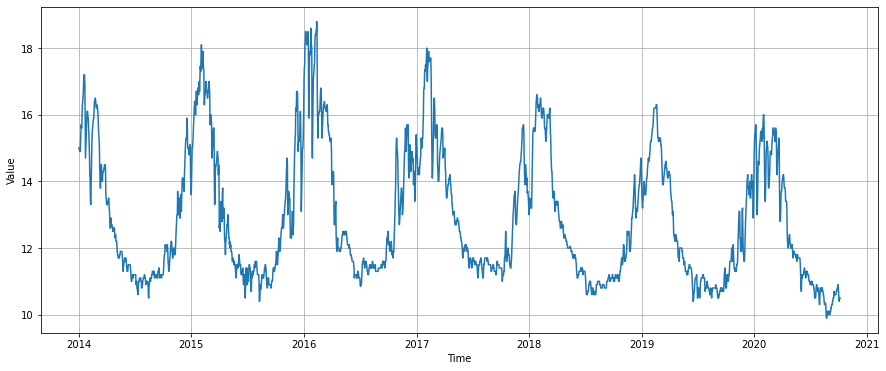

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

plt.figure(figsize=(15,6))
plot_series(time, series)

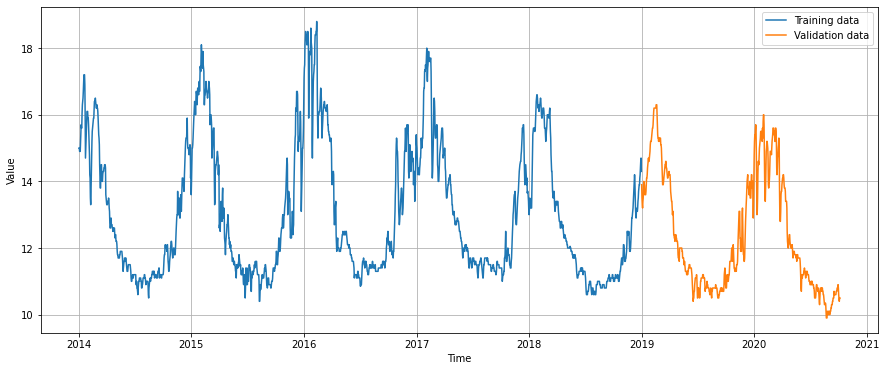

In [ ]:
#splitting the data into training and validation
#there's 6 years of data, we're gonna use 4 years for training and 2 for validation

split_time = 365*5
#training data
time_train = time[:split_time]
x_train = series[:split_time]
#validation data
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(15,6))
plot_series(time_train, x_train)
plot_series(time_valid, x_valid)
plt.legend(["Training data", "Validation data"])
plt.show()



# 1. Classic Time Series Approach

## Naive Forecasting

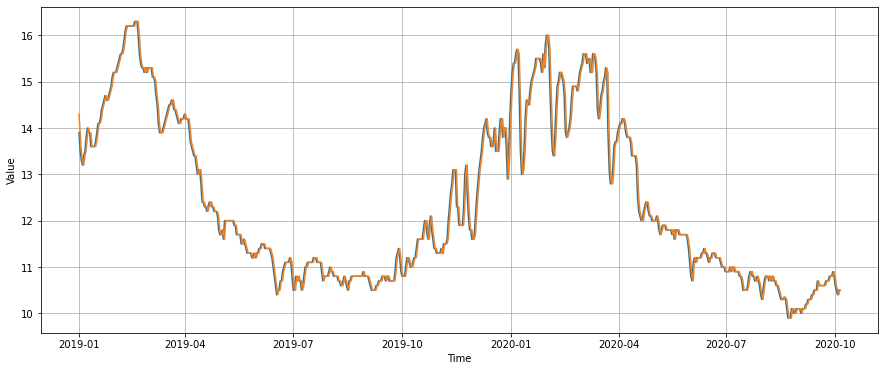

In [ ]:
#in order to define a baseline, let's use a naive forecasting aproach 
naive_forecast = series[split_time-1:-1] #yesterday's temperature

plt.figure(figsize=(15,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)
plt.show()

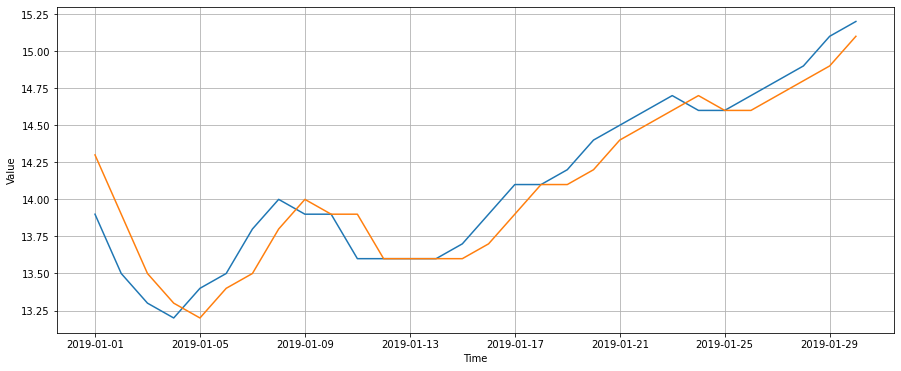

In [ ]:
#lets zoom in to see the lag
plt.figure(figsize=(15,6))
plot_series(time_valid[:30], x_valid[:30])
plot_series(time_valid[:30], naive_forecast[:30])
plt.show()

In [ ]:
#lets compute the mean absolute error (MAE) and mean squared error (MSE) between the series and the naive forescasting
print("MAE:",tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())
print("MSE", tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())

MAE: 0.1206521739130435
MSE 0.040908385093167694


El error absoluto promedio de un modelo naive es de 1.3 grados bastante bueno y dificil de mejorar.

Ahora provemos con moving average

## Moving Average

In [ ]:
#so naive forecasting is our baseline, lets try if moving average is better
def moving_average_forecast(series, window_size):
  """Forecast the mean of the last values (window sise).
  If window_size = 1, means its the same as naive forecasting"""
  forecast = []
  for time in range(len(series)-window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

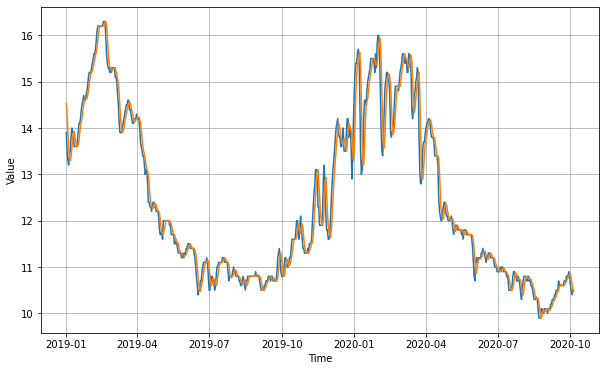

In [ ]:
window_size = 3
moving_avg = moving_average_forecast(series, window_size)[split_time - window_size:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [ ]:
print("MAE:", tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())
print("MSE:", tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())

MAE: 0.2032608695652175
MSE: 0.1023757763975155


## Moving Average with Differencing

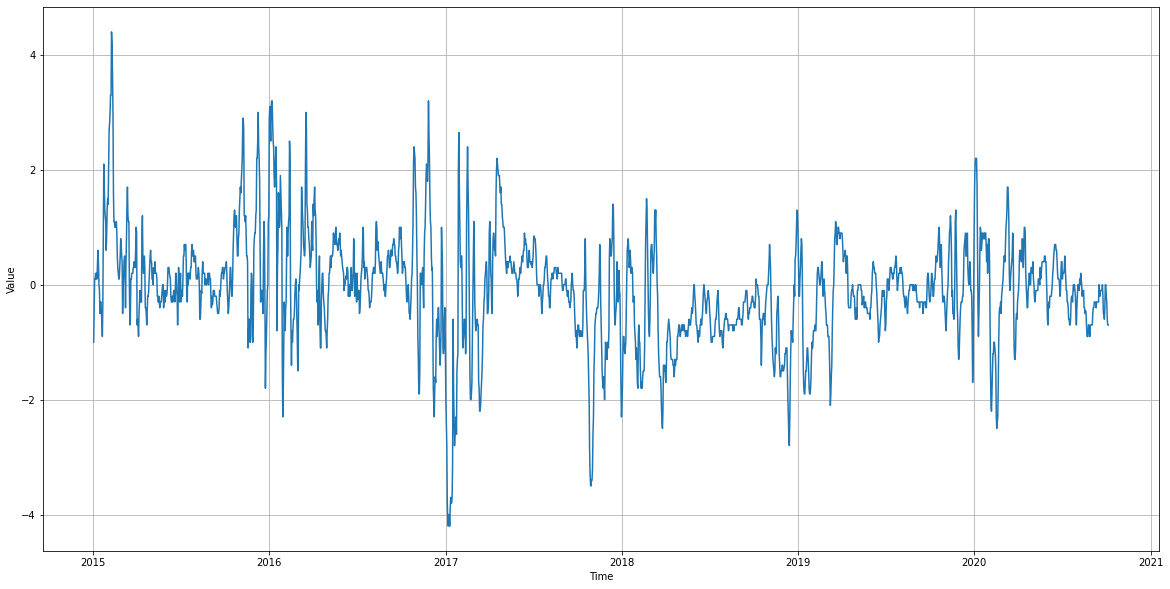

In [ ]:
#it did a little bit better than naive forecasting but almost the same
#moving average doent anticipate trend and seasonality, lets try removing them by using differencing
#since the seasonality period is 365 days we will substract the value at time t - 365 from the value at time t

diff_series = (series[365:]-series[:-365])
diff_time = time[365:]

plt.figure(figsize=(20,10))
plot_series(diff_time, diff_series)
plt.show()

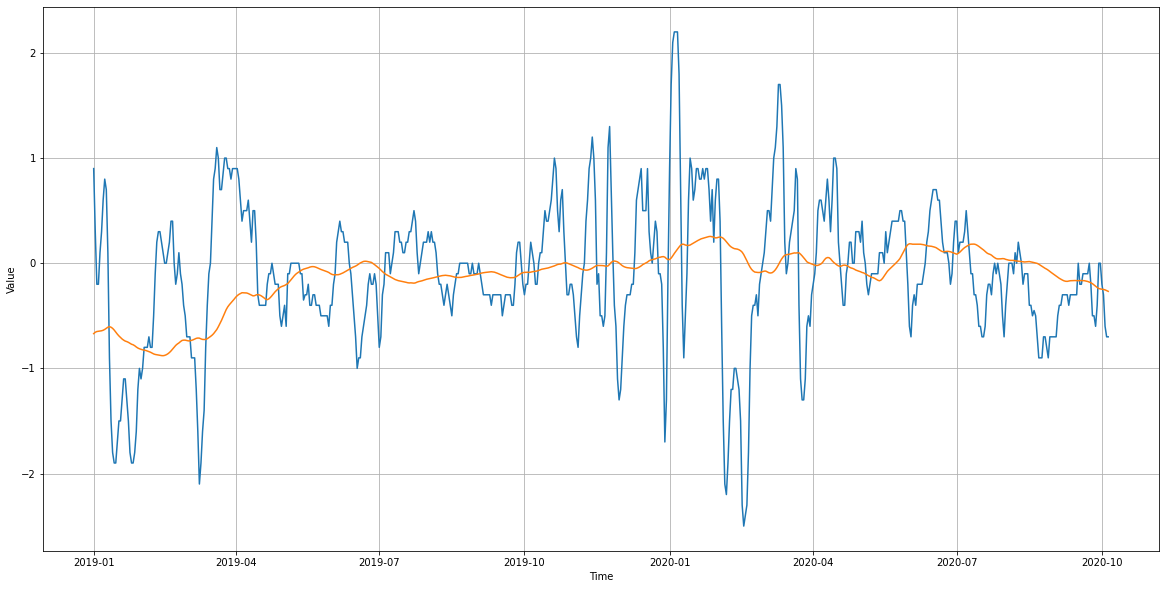

In [ ]:
#with no trend nor seasonality lets reuse moving average
diff_moving_avg = moving_average_forecast(diff_series, 100)[split_time-365 - 100:]

plt.figure(figsize=(20,10))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

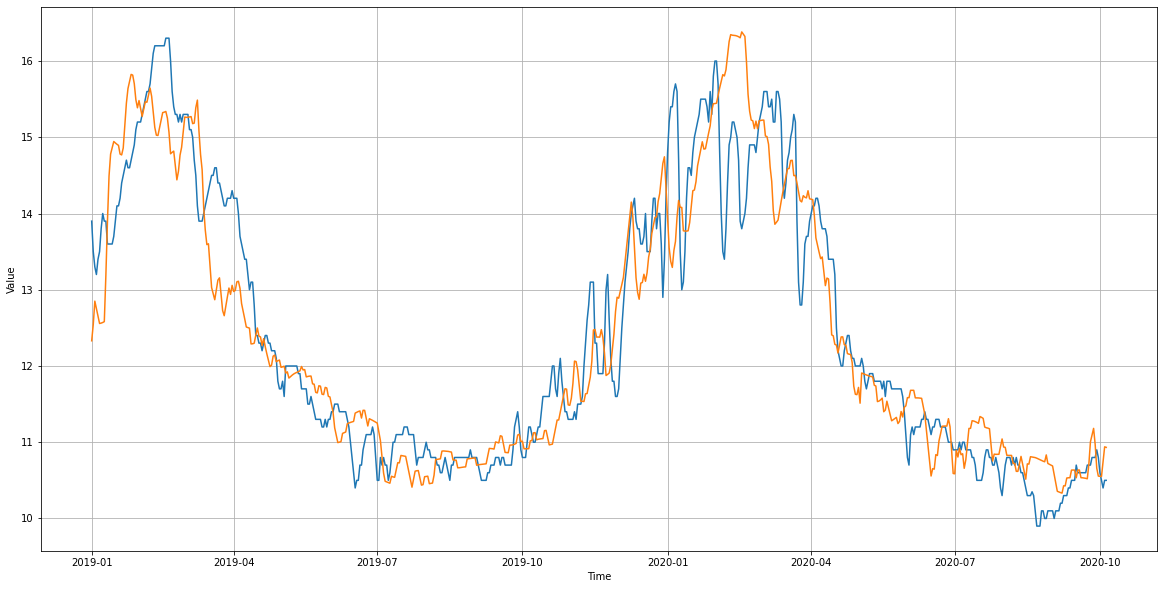

In [ ]:
#now lets bring back the trend and seasonality
diff_moving_avg_plus_past = diff_moving_avg + series[split_time-365:-365]
plt.figure(figsize=(20,10))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [ ]:
print("MAE:", tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())
print("MSE:", tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())

MAE: 0.4893571428571429
MSE: 0.446552079968944


## Moving Average with Differencing and Smoothing

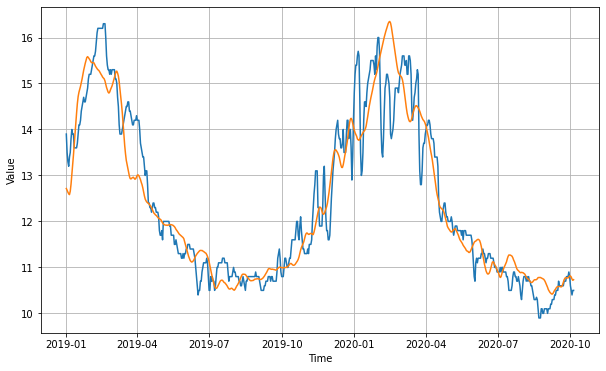

In [ ]:
#not better than naive forecastig, a lot of noise due to past 365 days noise, lets smooth past values too (with moving averaging). 

diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [ ]:
print("MAE:", tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print("MSE:", tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

MAE: 0.45139285714285726
MSE: 0.3763915830745341


## left to do:


1.   ARMA: Auto regressive moving average
2.  ARIMA
3. SARIMA




# 2. Deep Learning

## Fully Connected Neural Network

In [ ]:
#helper function for deep learning
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  #transform the series to dataset
  dataset = tf.data.Dataset.from_tensor_slices(series)
  #adding window, drop_remainder = True makes the resulting data set with the same shape
  dataset = dataset.window(window_size +1, shift=1, drop_remainder=True)
  #flattening the dataset and keeping the order
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  #shuffling
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  #fetch in batches
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
#with the helper function ready we are gonna fetch the data into a fully connected neural network

model = tf.keras.models.Sequential([
              tf.keras.layers.Dense(7, input_shape=[window_size], activation="relu"),
              tf.keras.layers.Dense(64, activation="relu"),
              tf.keras.layers.Dense(128, activation="relu"),
              tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam())
history = model.fit(dataset, epochs=300, verbose=1)

Epoch 1/300
56/56 [==============================] - 0s 5ms/step - loss: 2.2094
Epoch 2/300
56/56 [==============================] - 0s 4ms/step - loss: 0.4939
Epoch 3/300
56/56 [==============================] - 0s 4ms/step - loss: 0.4594
Epoch 4/300
56/56 [==============================] - 0s 4ms/step - loss: 0.4427
Epoch 5/300
56/56 [==============================] - 0s 4ms/step - loss: 0.3414
Epoch 6/300
56/56 [==============================] - 0s 5ms/step - loss: 0.2847
Epoch 7/300
56/56 [==============================] - 0s 4ms/step - loss: 0.2524
Epoch 8/300
56/56 [==============================] - 0s 4ms/step - loss: 0.2347
Epoch 9/300
56/56 [==============================] - 0s 4ms/step - loss: 0.2094
Epoch 10/300
56/56 [==============================] - 0s 4ms/step - loss: 0.1939
Epoch 11/300
56/56 [==============================] - 0s 4ms/step - loss: 0.2058
Epoch 12/300
56/56 [==============================] - 0s 4ms/step - loss: 0.1825
Epoch 13/300
56/56 [=================

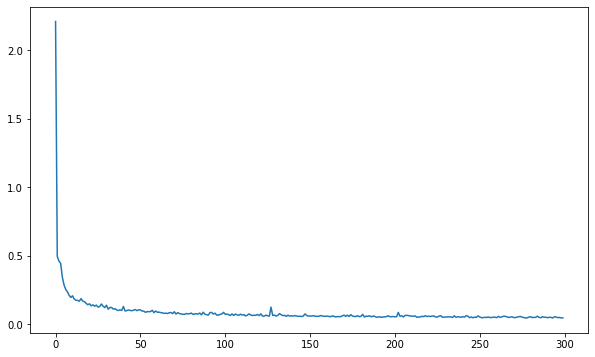

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history["loss"])
plt.show()

100%|██████████| 644/644 [00:19<00:00, 32.32it/s]


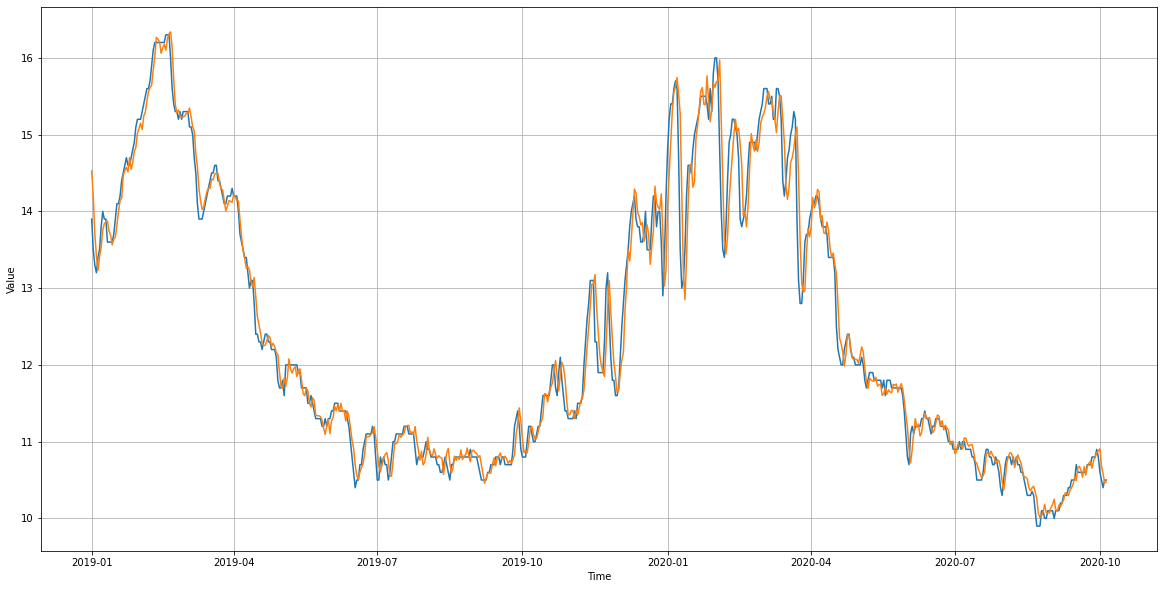

In [ ]:
#forecasting
def forecasting():
  forecast = []
  for time in tqdm(range(len(x_valid))):
    forecast.append(model.predict(series[split_time - window_size + time: split_time + time][np.newaxis]))
  #slicing just the validation part
  #forecast = forecast[window_size:]
  results = np.array(forecast)[:, 0, 0]

  plt.figure(figsize=(20,10))
  plot_series(time_valid, x_valid)
  plot_series(time_valid, results)
  plt.show()
forecasting()

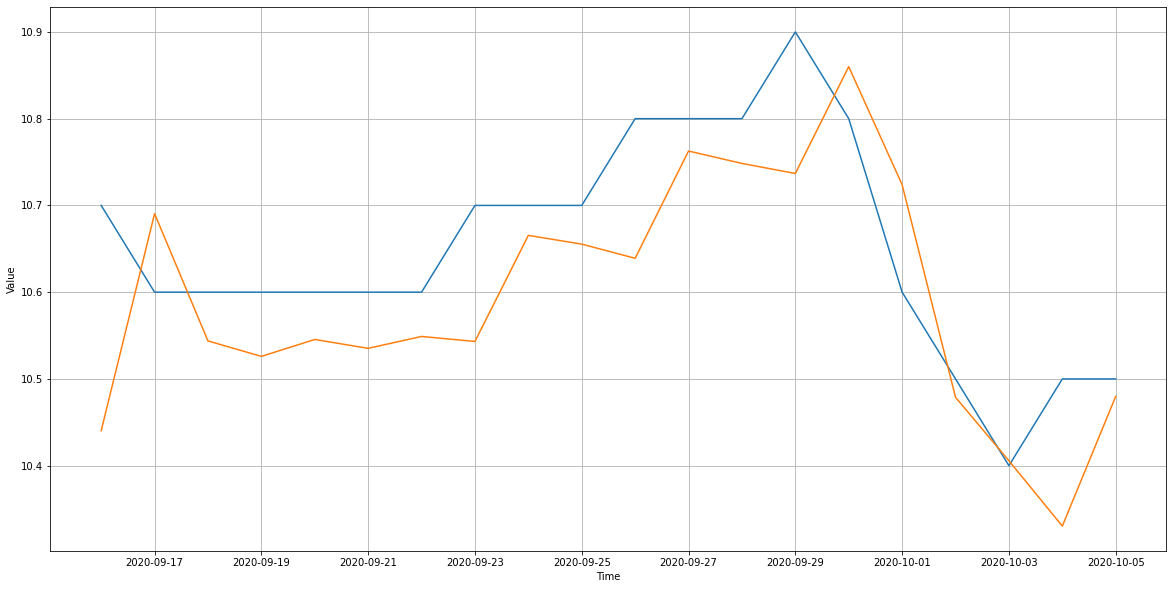

In [ ]:
plt.figure(figsize=(20,10))
plot_series(time_valid[-20:], x_valid[-20:])
plot_series(time_valid[-20:], results[-20:])
plt.show()

In [ ]:
print("MAE:", tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print("MSE:", tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

MAE: 0.1469745
MSE: 0.04010672


Levemente mejor que el baseline, ahora provemos con Deep Learning RNN y LSTM

## RNN: Recurrent Neural Networks

In [ ]:
#Deep learning with Recurrent Neural Networks
#clearing session
tf.keras.backend.clear_session()
tf.random.set_seed(12)
np.random.seed(12)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

#lr schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
15/15 [==============================] - 0s 15ms/step - loss: 58.7961 - mae: 59.2952
Epoch 2/100
15/15 [==============================] - 0s 14ms/step - loss: 58.7840 - mae: 59.2832
Epoch 3/100
15/15 [==============================] - 0s 14ms/step - loss: 58.7673 - mae: 59.2664
Epoch 4/100
15/15 [==============================] - 0s 14ms/step - loss: 58.7479 - mae: 59.2470
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - loss: 58.7260 - mae: 59.2251
Epoch 6/100
15/15 [==============================] - 0s 15ms/step - loss: 58.7014 - mae: 59.2006
Epoch 7/100
15/15 [==============================] - 0s 14ms/step - loss: 58.6739 - mae: 59.1731
Epoch 8/100
15/15 [==============================] - 0s 14ms/step - loss: 58.6431 - mae: 59.1423
Epoch 9/100
15/15 [==============================] - 0s 15ms/step - loss: 58.6086 - mae: 59.1078
Epoch 10/100
15/15 [==============================] - 0s 13ms/step - loss: 58.5700 - mae: 59.0692
Epoch 11/100
15/15 [=========

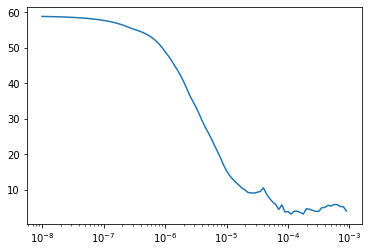

In [ ]:
#plotting the semilog of the learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.show()

In [ ]:
#doing it again but with the fixed lr
#clearing session
tf.keras.backend.clear_session()
tf.random.set_seed(12)
np.random.seed(12)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Conv1D(16, 4, activation="relu", padding='valid'),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500, verbose=1)

Epoch 1/500
14/14 [==============================] - 1s 77ms/step - loss: 43.7545 - mae: 44.2518
Epoch 2/500
14/14 [==============================] - 1s 81ms/step - loss: 38.0688 - mae: 38.5653
Epoch 3/500
14/14 [==============================] - 1s 77ms/step - loss: 32.9486 - mae: 33.4407
Epoch 4/500
14/14 [==============================] - 1s 77ms/step - loss: 29.0857 - mae: 29.5751
Epoch 5/500
14/14 [==============================] - 1s 76ms/step - loss: 26.1915 - mae: 26.6781
Epoch 6/500
14/14 [==============================] - 1s 79ms/step - loss: 24.2463 - mae: 24.7313
Epoch 7/500
14/14 [==============================] - 1s 78ms/step - loss: 22.6244 - mae: 23.1070
Epoch 8/500
14/14 [==============================] - 1s 77ms/step - loss: 21.1464 - mae: 21.6272
Epoch 9/500
14/14 [==============================] - 1s 76ms/step - loss: 19.8014 - mae: 20.2817
Epoch 10/500
14/14 [==============================] - 1s 79ms/step - loss: 18.5319 - mae: 19.0124
Epoch 11/500
14/14 [=========

<Figure size 432x288 with 0 Axes>

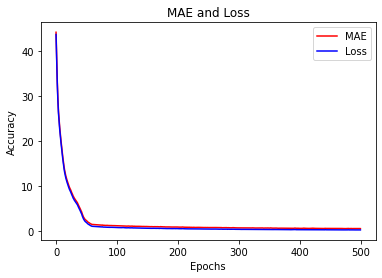

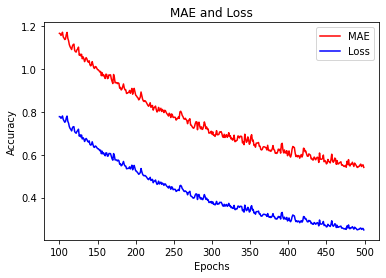

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[100:]
mae_zoom = mae[100:]
loss_zoom = loss[100:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

100%|██████████| 644/644 [00:25<00:00, 24.88it/s]


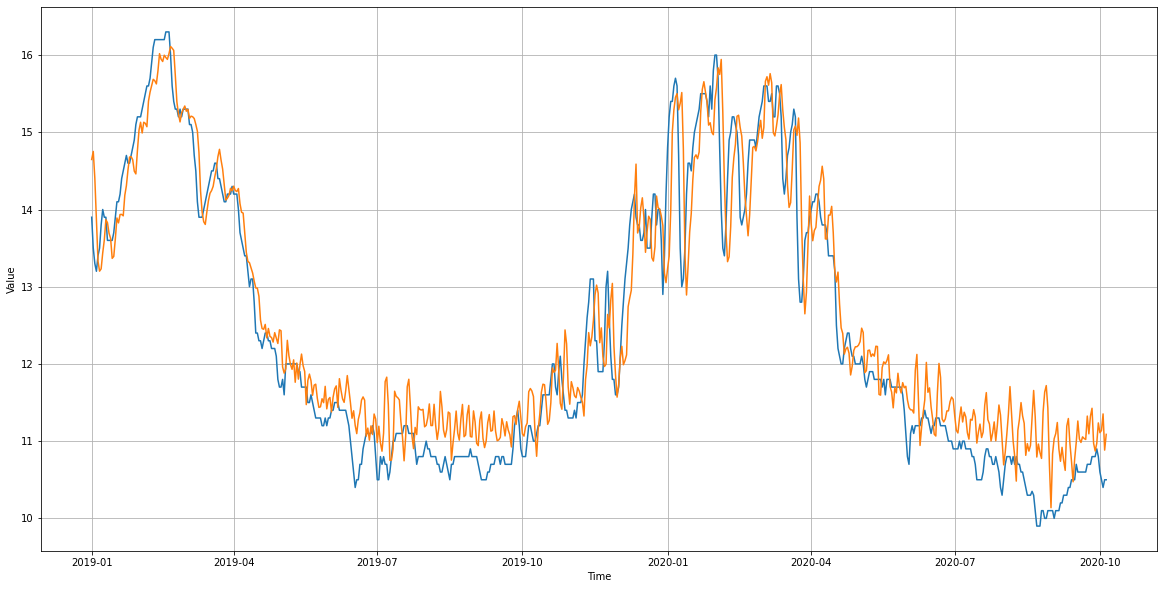

In [ ]:
#forecasting
forecasting()

In [ ]:
print("MAE:", tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print("MSE:", tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

MAE: 0.1469745
MSE: 0.04010672


## LSTM: Long Shot Term Memory RNN

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(12)
np.random.seed(12)

tf.keras.backend.clear_session()

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential(
    [
     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
     tf.keras.layers.Dense(1),
     tf.keras.layers.Lambda(lambda x: x * 100.0)
    ]
)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

48/48 [==============================] - 2s 43ms/step - loss: 62.8454 - mae: 63.3454
Epoch 2/100
48/48 [==============================] - 2s 41ms/step - loss: 60.2349 - mae: 60.7349
Epoch 3/100
48/48 [==============================] - 2s 41ms/step - loss: 57.0077 - mae: 57.5077
Epoch 4/100
48/48 [==============================] - 2s 41ms/step - loss: 53.1233 - mae: 53.6233
Epoch 5/100
48/48 [==============================] - 2s 41ms/step - loss: 48.5319 - mae: 49.0319
Epoch 6/100
48/48 [====

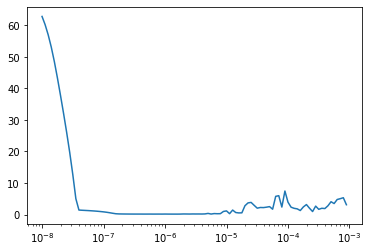

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(),metrics=["mae"])
history = model.fit(dataset,epochs=400,verbose=1)

Epoch 1/400
56/56 [==============================] - 1s 16ms/step - loss: 13.5190 - mae: 2.2816
Epoch 2/400
56/56 [==============================] - 1s 16ms/step - loss: 0.2921 - mae: 0.3869
Epoch 3/400
56/56 [==============================] - 1s 15ms/step - loss: 0.2573 - mae: 0.3638
Epoch 4/400
56/56 [==============================] - 1s 15ms/step - loss: 0.2268 - mae: 0.3285
Epoch 5/400
56/56 [==============================] - 1s 16ms/step - loss: 0.2252 - mae: 0.3360
Epoch 6/400
56/56 [==============================] - 1s 15ms/step - loss: 0.1942 - mae: 0.3056
Epoch 7/400
56/56 [==============================] - 1s 15ms/step - loss: 0.2139 - mae: 0.3335
Epoch 8/400
56/56 [==============================] - 1s 15ms/step - loss: 0.2458 - mae: 0.3736
Epoch 9/400
56/56 [==============================] - 1s 16ms/step - loss: 0.1868 - mae: 0.3056
Epoch 10/400
56/56 [==============================] - 1s 15ms/step - loss: 0.2452 - mae: 0.3758
Epoch 11/400
56/56 [============================

<Figure size 432x288 with 0 Axes>

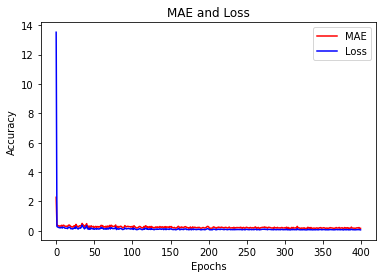

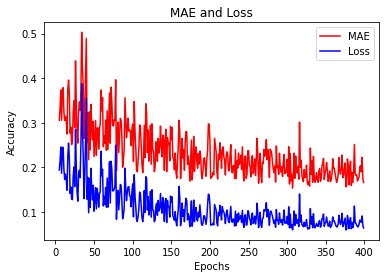

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------

epochs_zoom = epochs[5:]
mae_zoom = mae[5:]
loss_zoom = loss[5:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()


100%|██████████| 644/644 [00:25<00:00, 25.40it/s]


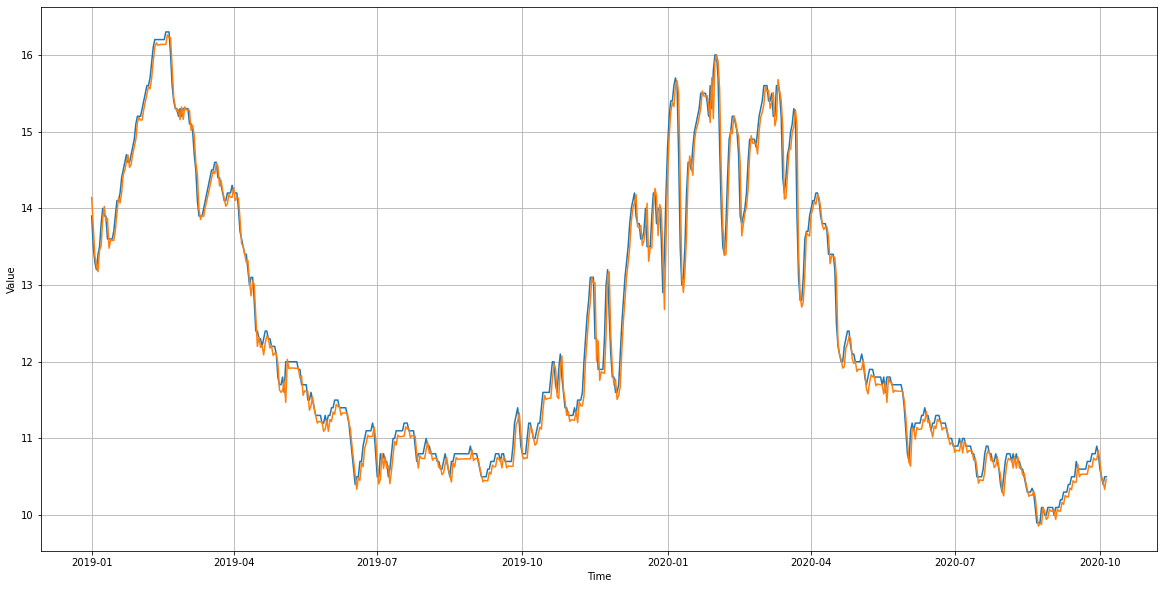

In [ ]:
forecasting()

In [ ]:
print("MAE:", tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print("MSE:", tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

MAE: 0.23855229
MSE: 0.092869915


## GRU + CNN : Gated Recurrent Units + Convolutional Neural Network

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid"),
    tf.keras.layers.GRU(20, return_sequences=True),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.GRU(20),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam", metrics=["mae"])
history = model.fit(dataset, epochs=200)

Epoch 1/200
56/56 [==============================] - 0s 8ms/step - loss: 110.7878 - mae: 10.2882
Epoch 2/200
56/56 [==============================] - 0s 7ms/step - loss: 66.8366 - mae: 7.9184
Epoch 3/200
56/56 [==============================] - 0s 8ms/step - loss: 47.2023 - mae: 6.5686
Epoch 4/200
56/56 [==============================] - 0s 7ms/step - loss: 34.1953 - mae: 5.4958
Epoch 5/200
56/56 [==============================] - 0s 7ms/step - loss: 24.7763 - mae: 4.5602
Epoch 6/200
56/56 [==============================] - 0s 7ms/step - loss: 17.9614 - mae: 3.7424
Epoch 7/200
56/56 [==============================] - 0s 8ms/step - loss: 13.1284 - mae: 3.0319
Epoch 8/200
56/56 [==============================] - 0s 7ms/step - loss: 9.7906 - mae: 2.4263
Epoch 9/200
56/56 [==============================] - 0s 8ms/step - loss: 7.5397 - mae: 1.9531
Epoch 10/200
56/56 [==============================] - 0s 8ms/step - loss: 6.0773 - mae: 1.6960
Epoch 11/200
56/56 [==============================

100%|██████████| 2409/2409 [01:24<00:00, 28.34it/s]


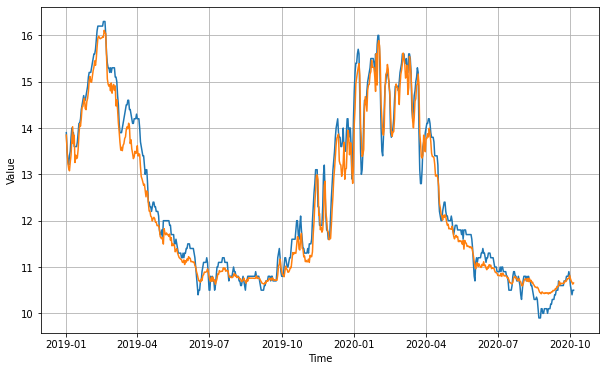

In [ ]:
forecast = []
results = []
for time in tqdm(range(len(series) - window_size)):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
print("MAE:", tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())
print("MSE:", tf.keras.metrics.mean_squared_error(x_valid, results).numpy())

MAE: 0.23855229
MSE: 0.092869915


<Figure size 432x288 with 0 Axes>

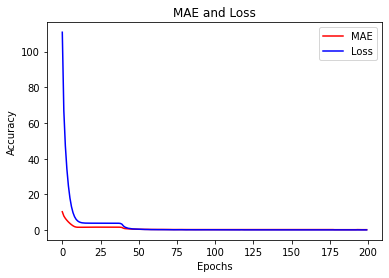

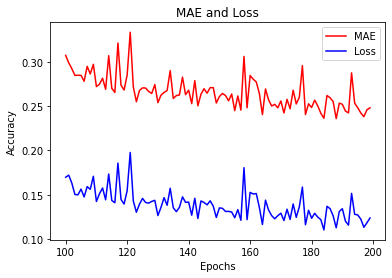

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------

epochs_zoom = epochs[100:]
mae_zoom = mae[100:]
loss_zoom = loss[100:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

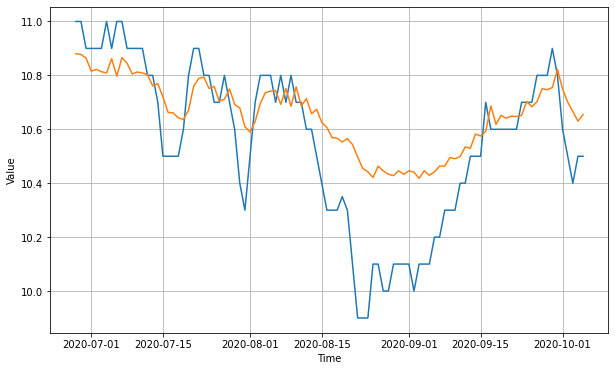

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], results[-100:])